# PREDICTING KICKSTARTER SUCCESS

In [142]:
# import relevant libraries
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from pandas.io.json import json_normalize
import json
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import (accuracy_score, classification_report,confusion_matrix, precision_score, 
                             recall_score, f1_score, roc_curve, roc_auc_score, average_precision_score, 
                             precision_recall_curve, auc)
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
%matplotlib inline

In [2]:
# import the dataset and have a first look
df = pd.read_csv("data/train.zip", low_memory=False)
pd.options.display.max_columns = None
print(df.shape)
df.head()

(105603, 26)


,id,photo,name,blurb,goal,slug,disable_communication,country,currency,currency_symbol,currency_trailing_code,deadline,created_at,launched_at,static_usd_rate,creator,location,category,profile,urls,source_url,friends,is_starred,is_backing,permissions,state
0,663816109,"{""small"":""https://ksr-ugc.imgix.net/assets/012...",Angular - Where Modern Art meets Cards,Angular is a minimalist card design for simpli...,17380.0,angular-where-modern-art-meets-cards,False,US,USD,$,True,1459283229,1455845363,1456694829,1.000000,"{""urls"":{""web"":{""user"":""https://www.kickstarte...","{""country"":""US"",""urls"":{""web"":{""discover"":""htt...","{""urls"":{""web"":{""discover"":""http://www.kicksta...","{""background_image_opacity"":0.8,""should_show_f...","{""web"":{""project"":""https://www.kickstarter.com...",https://www.kickstarter.com/discover/categorie...,NaN,NaN,NaN,NaN,failed
1,1462931821,"{""small"":""https://ksr-ugc.imgix.net/assets/014...",Ladybeard is KAWAII-CORE,Original songs and music videos to jump start ...,24000.0,ladybeard-is-kawaii-core,False,US,USD,$,True,1484110800,1475568868,1480946454,1.000000,"{""urls"":{""web"":{""user"":""https://www.kickstarte...","{""country"":""JP"",""urls"":{""web"":{""discover"":""htt...","{""urls"":{""web"":{""discover"":""http://www.kicksta...","{""background_image_opacity"":0.8,""should_show_f...","{""web"":{""project"":""https://www.kickstarter.com...",https://www.kickstarter.com/discover/categorie...,NaN,NaN,NaN,NaN,failed
2,1724358498,"{""small"":""https://ksr-ugc.imgix.net/assets/011...",Vegan Cafe Delivery Service in Vancouver BC,Our project is to launch a vegan lunch deliver...,40000.0,vegancafeca,False,CA,CAD,$,True,1408549628,1405218883,1405957628,0.926746,"{""urls"":{""web"":{""user"":""https://www.kickstarte...","{""country"":""CA"",""urls"":{""web"":{""discover"":""htt...","{""urls"":{""web"":{""discover"":""http://www.kicksta...","{""background_image_opacity"":0.8,""should_show_f...","{""web"":{""project"":""https://www.kickstarter.com...",https://www.kickstarter.com/discover/categorie...,NaN,NaN,NaN,NaN,failed
3,314918941,"{""small"":""https://ksr-ugc.imgix.net/assets/011...",Photoetched Rail Yard Exposition,I have developed a process of my own which tra...,1000.0,photoetched-rail-yard-exposition,False,US,USD,$,True,1364084914,1360627778,1361496514,1.000000,"{""urls"":{""web"":{""user"":""https://www.kickstarte...","{""country"":""US"",""urls"":{""web"":{""discover"":""htt...","{""urls"":{""web"":{""discover"":""http://www.kicksta...","{""background_image_opacity"":0.8,""should_show_f...","{""web"":{""project"":""https://www.kickstarter.com...",https://www.kickstarter.com/discover/categorie...,NaN,NaN,NaN,NaN,successful
4,1766165140,"{""small"":""https://ksr-ugc.imgix.net/assets/011...",Cinnamon Fletcher needs to be brought to life!,Need to pay an illustrator to bring my childre...,700.0,cinnamon-fletcher-needs-to-be-brought-to-life,False,GB,GBP,Â£,False,1382600001,1379704502,1380008001,1.602384,"{""urls"":{""web"":{""user"":""https://www.kickstarte...","{""country"":""GB"",""urls"":{""web"":{""discover"":""htt...","{""urls"":{""web"":{""discover"":""http://www.kicksta...","{""background_image_opacity"":0.8,""should_show_f...","{""web"":{""project"":""https://www.kickstarter.com...",https://www.kickstarter.com/discover/categorie...,NaN,NaN,NaN,NaN,failed


In [3]:
# Check data types and missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105603 entries, 0 to 105602
Data columns (total 26 columns):
id                        105603 non-null int64
photo                     105603 non-null object
name                      105601 non-null object
blurb                     105601 non-null object
goal                      105603 non-null float64
slug                      105603 non-null object
disable_communication     105603 non-null bool
country                   105603 non-null object
currency                  105603 non-null object
currency_symbol           105603 non-null object
currency_trailing_code    105603 non-null bool
deadline                  105603 non-null int64
created_at                105603 non-null int64
launched_at               105603 non-null int64
static_usd_rate           105603 non-null float64
creator                   105603 non-null object
location                  105128 non-null object
category                  105603 non-null object
profile      

A first look shows we have a number of columns with json data that should be further explored. While we have some columns with only mainly null entries, which can be dropped.

In [4]:
# Drop rows with few entries and extract json data
df_red = df.drop(["friends", "is_starred", "is_backing", "permissions"], axis=1)
                          
df_red["location"] = df_red["location"].fillna(df_red["location"].mode().iloc[0])

def normalize_json_column(df, column):
    """Extracts json data from specified column and concatanates with original df"""
    column_normalized_df = json_normalize(df[column].apply(json.loads))
    column_normalized_df.columns = list(map(lambda x: "{}.{}".format(column,x),column_normalized_df.columns))
    result = pd.concat([df, column_normalized_df], axis=1, sort=False)
    del result[column]
    return result

normalized = normalize_json_column(df_red, 'photo')
normalized = normalize_json_column(normalized, 'creator')
normalized = normalize_json_column(normalized, 'location')
normalized = normalize_json_column(normalized, 'category')
normalized = normalize_json_column(normalized, 'profile')
normalized = normalize_json_column(normalized, 'urls')

# Check new flattened dataframe
print(normalized.shape)
normalized.head()

(105603, 79)


,id,name,blurb,goal,slug,disable_communication,country,currency,currency_symbol,currency_trailing_code,deadline,created_at,launched_at,static_usd_rate,source_url,state,photo.1024x576,photo.1536x864,photo.ed,photo.full,photo.key,photo.little,photo.med,photo.small,photo.thumb,creator.avatar.medium,creator.avatar.small,creator.avatar.thumb,creator.id,creator.is_registered,creator.name,creator.slug,creator.urls.api.user,creator.urls.web.user,location.country,location.displayable_name,location.id,location.is_root,location.name,location.short_name,location.slug,location.state,location.type,location.urls.api.nearby_projects,location.urls.web.discover,location.urls.web.location,category.color,category.id,category.name,category.parent_id,category.position,category.slug,category.urls.web.discover,profile.background_color,profile.background_image_attributes.id,profile.background_image_attributes.image_urls.baseball_card,profile.background_image_attributes.image_urls.default,profile.background_image_opacity,profile.blurb,profile.feature_image_attributes.id,profile.feature_image_attributes.image_urls.baseball_card,profile.feature_image_attributes.image_urls.default,profile.id,profile.link_background_color,profile.link_text,profile.link_text_color,profile.link_url,profile.name,profile.project_id,profile.should_show_feature_image_section,profile.show_feature_image,profile.state,profile.state_changed_at,profile.text_color,urls.api.message_creator,urls.api.star,urls.web.message_creator,urls.web.project,urls.web.rewards
0,663816109,Angular - Where Modern Art meets Cards,Angular is a minimalist card design for simpli...,17380.0,angular-where-modern-art-meets-cards,False,US,USD,$,True,1459283229,1455845363,1456694829,1.000000,https://www.kickstarter.com/discover/categorie...,failed,https://ksr-ugc.imgix.net/assets/012/384/964/7...,https://ksr-ugc.imgix.net/assets/012/384/964/7...,https://ksr-ugc.imgix.net/assets/012/384/964/7...,https://ksr-ugc.imgix.net/assets/012/384/964/7...,assets/012/384/964/7a20ef8917d7de846e9b6bf66a3...,https://ksr-ugc.imgix.net/assets/012/384/964/7...,https://ksr-ugc.imgix.net/assets/012/384/964/7...,https://ksr-ugc.imgix.net/assets/012/384/964/7...,https://ksr-ugc.imgix.net/assets/012/384/964/7...,https://ksr-ugc.imgix.net/assets/009/870/528/9...,https://ksr-ugc.imgix.net/assets/009/870/528/9...,https://ksr-ugc.imgix.net/assets/009/870/528/9...,200609383,True,Yujian Tang,NaN,https://api.kickstarter.com/v1/users/200609383...,https://www.kickstarter.com/profile/200609383,US,"Raleigh, NC",2478307,False,Raleigh,"Raleigh, NC",raleigh-nc,NC,Town,https://api.kickstarter.com/v1/discover?signat...,https://www.kickstarter.com/discover/places/ra...,https://www.kickstarter.com/locations/raleigh-nc,51627,273,Playing Cards,12,4,games/playing cards,http://www.kickstarter.com/discover/categories...,None,NaN,NaN,NaN,0.8,None,NaN,https://ksr-ugc.imgix.net/assets/012/384/964/7...,https://ksr-ugc.imgix.net/assets/012/384/964/7...,2382138,None,None,None,None,None,2382138,True,False,inactive,1455845363,None,NaN,NaN,NaN,https://www.kickstarter.com/projects/200609383...,https://www.kickstarter.com/projects/200609383...
1,1462931821,Ladybeard is KAWAII-CORE,Original songs and music videos to jump start ...,24000.0,ladybeard-is-kawaii-core,False,US,USD,$,True,1484110800,1475568868,1480946454,1.000000,https://www.kickstarter.com/discover/categorie...,failed,https://ksr-ugc.imgix.net/assets/014/338/815/4...,https://ksr-ugc.imgix.net/assets/014/338/815/4...,https://ksr-ugc.imgix.net/assets/014/338/815/4...,https://ksr-ugc.imgix.net/assets/014/338/815/4...,assets/014/338/815/401f5d31dceb36865d565796bec...,https://ksr-ugc.imgix.net/assets/014/338/815/4...,https://ksr-ugc.imgix.net/assets/014/338/815/4...,https://ksr-ugc.imgix.net/assets/014/338/815/4...,https://ksr-ugc.imgix.net/assets/014/338/815/4...,https://ksr-ugc.imgix.net/assets/014/646/683/6...,https://ksr-ugc.imgix.net/assets/014/646/683/6...,https://ksr-ugc.imgix.net/assets/014/646/683/6...,1

In [5]:
normalized.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105603 entries, 0 to 105602
Data columns (total 79 columns):
id                                                              105603 non-null int64
name                                                            105601 non-null object
blurb                                                           105601 non-null object
goal                                                            105603 non-null float64
slug                                                            105603 non-null object
disable_communication                                           105603 non-null bool
country                                                         105603 non-null object
currency                                                        105603 non-null object
currency_symbol                                                 105603 non-null object
currency_trailing_code                                          105603 non-null bool
deadline               

In [6]:
normalized.nunique()

id                                                              105603
name                                                            105304
blurb                                                           105123
goal                                                              3457
slug                                                            105603
disable_communication                                                1
country                                                             21
currency                                                            13
currency_symbol                                                      5
currency_trailing_code                                               2
deadline                                                        100246
created_at                                                      105561
launched_at                                                     105553
static_usd_rate                                                   5650
source

Looking at the data we can remove several columns that are clearly not going to influence the success of the project. Data from the "photo" and "urls" json columns only contain links and can be dropped, as can a number of columns from the "profile", "creator" and "category columns. "disable_communication" is always False, so can be dropped. There is also some repeated data, eg. "country" and "location.country" columns.

In [23]:
# We can remove unwanted features or in this case select those of interest
df_trimmed = normalized[['name', 'blurb', 'goal', 'currency', 'currency_trailing_code', 'deadline', 'created_at',
                         'launched_at', 'static_usd_rate', 'state', 'location.country', 'location.state',
                         'location.id', 'location.name', 'location.type', 'category.id', 'category.name',
                         'category.parent_id', 'profile.link_url', 'profile.state_changed_at', 'creator.slug']]

In [24]:
# Have a look at the trimmed datatframe
print(df_trimmed.shape)
df_trimmed.head()

(105603, 21)


,name,blurb,goal,currency,currency_trailing_code,deadline,created_at,launched_at,static_usd_rate,state,location.country,location.state,location.id,location.name,location.type,category.id,category.name,category.parent_id,profile.link_url,profile.state_changed_at,creator.slug
0,Angular - Where Modern Art meets Cards,Angular is a minimalist card design for simpli...,17380.0,USD,True,1459283229,1455845363,1456694829,1.000000,failed,US,NC,2478307,Raleigh,Town,273,Playing Cards,12,None,1455845363,NaN
1,Ladybeard is KAWAII-CORE,Original songs and music videos to jump start ...,24000.0,USD,True,1484110800,1475568868,1480946454,1.000000,failed,JP,Tokyo Prefecture,1118370,Tokyo,Town,42,Pop,14,None,1475568868,NaN
2,Vegan Cafe Delivery Service in Vancouver BC,Our project is to launch a vegan lunch deliver...,40000.0,CAD,True,1408549628,1405218883,1405957628,0.926746,failed,CA,BC,9807,Vancouver,Town,315,Vegan,10,None,1425915865,NaN
3,Photoetched Rail Yard Exposition,I have developed a process of my own which tra...,1000.0,USD,True,1364084914,1360627778,1361496514,1.000000,successful,US,NM,2352824,Albuquerque,Town,54,Mixed Media,1,None,1425915825,NaN
4,Cinnamon Fletcher needs to be brought to life!,Need to pay an illustrator to bring my childre...,700.0,GBP,False,1382600001,1379704502,1380008001,1.602384,failed,GB,England,26062,Leicester,Town,46,Children's Books,18,None,1425915838,NaN


In [25]:
# Change the target variable to 0 and 1s
df_trimmed['state'] = df_trimmed['state'].replace(['failed', 'successful'], [0, 1])

C:\Users\david\Miniconda3\envs\ads03\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [26]:
# Convert the following columns to 0 and 1s depending on if they have a null or valid entry
df_trimmed["profile.link_url"] = df_trimmed["profile.link_url"].notnull().astype('int')
df_trimmed["creator.slug"] = df_trimmed["creator.slug"].notnull().astype('int')

C:\Users\david\Miniconda3\envs\ads03\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\david\Miniconda3\envs\ads03\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [27]:
df_trimmed.head()

,name,blurb,goal,currency,currency_trailing_code,deadline,created_at,launched_at,static_usd_rate,state,location.country,location.state,location.id,location.name,location.type,category.id,category.name,category.parent_id,profile.link_url,profile.state_changed_at,creator.slug
0,Angular - Where Modern Art meets Cards,Angular is a minimalist card design for simpli...,17380.0,USD,True,1459283229,1455845363,1456694829,1.000000,0,US,NC,2478307,Raleigh,Town,273,Playing Cards,12,0,1455845363,0
1,Ladybeard is KAWAII-CORE,Original songs and music videos to jump start ...,24000.0,USD,True,1484110800,1475568868,1480946454,1.000000,0,JP,Tokyo Prefecture,1118370,Tokyo,Town,42,Pop,14,0,1475568868,0
2,Vegan Cafe Delivery Service in Vancouver BC,Our project is to launch a vegan lunch deliver...,40000.0,CAD,True,1408549628,1405218883,1405957628,0.926746,0,CA,BC,9807,Vancouver,Town,315,Vegan,10,0,1425915865,0
3,Photoetched Rail Yard Exposition,I have developed a process of my own which tra...,1000.0,USD,True,1364084914,1360627778,1361496514,1.000000,1,US,NM,2352824,Albuquerque,Town,54,Mixed Media,1,0,1425915825,0
4,Cinnamon Fletcher needs to be brought to life!,Need to pay an illustrator to bring my childre...,700.0,GBP,False,1382600001,1379704502,1380008001,1.602384,0,GB,England,26062,Leicester,Town,46,Children's Books,18,0,1425915838,0


In [28]:
# Let's check the proportion of successful projects. In this dataset we see the success:fail ratio is almost 1:1
df_trimmed["state"].value_counts()

0    53046
1    52557
Name: state, dtype: int64

### Feature Engineering
#### Looking at the features and what we could imagine might effect the outcome of a kickstarter project, we can do some simple feature engineering. We can standardize the "goal" feature in USD by multiplyinh by the "static_usd_rate". We can measure the character length of the "name" and "blurb" features. We can generate a "proj_duration" feature as well as lookingat when the project was launched (year and month) to see what effect, if any they have on the "state".

In [29]:
df_trimmed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105603 entries, 0 to 105602
Data columns (total 21 columns):
name                        105601 non-null object
blurb                       105601 non-null object
goal                        105603 non-null float64
currency                    105603 non-null object
currency_trailing_code      105603 non-null bool
deadline                    105603 non-null int64
created_at                  105603 non-null int64
launched_at                 105603 non-null int64
static_usd_rate             105603 non-null float64
state                       105603 non-null int64
location.country            105603 non-null object
location.state              105585 non-null object
location.id                 105603 non-null int64
location.name               105603 non-null object
location.type               105603 non-null object
category.id                 105603 non-null int64
category.name               105603 non-null object
category.parent_id          

In [30]:
# Fill missing values in location.state with most frequent
df_trimmed["location.state"] = df_trimmed["location.state"].fillna(df_trimmed["location.state"].mode().iloc[0])

# Create features to measure length of name and blurb entries and then set remaining missing values to 0
df_trimmed["name_count"] = df_trimmed["name"].str.len()
df_trimmed["blurb_count"] = df_trimmed["blurb"].str.len()
df_trimmed = df_trimmed.fillna(0)

# Create feature to standardize the goal value in usd, measure project length and extract when project was launched (year and month)
df_trimmed["goal_std"] = df_trimmed["goal"] * df_trimmed["static_usd_rate"]
df_trimmed["proj_duration"] = df_trimmed["deadline"] - df_trimmed["launched_at"]
df_trimmed["launched_at"] = pd.to_datetime(df_trimmed["launched_at"], unit='s')
df_trimmed["la_month"] = df_trimmed["launched_at"].dt.month
df_trimmed["la_year"] = df_trimmed["launched_at"].dt.year

C:\Users\david\Miniconda3\envs\ads03\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\david\Miniconda3\envs\ads03\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\david\Miniconda3\envs\ads03\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

In [31]:
# We can then drop certain columns
df_trimmed = df_trimmed.drop(["name", "blurb", "goal", "deadline", "created_at", "launched_at", "static_usd_rate"], axis=1)

In [32]:
# Let's have a look at the new dataframe
print(df_trimmed.shape)
df_trimmed.head()

(105603, 20)


,currency,currency_trailing_code,state,location.country,location.state,location.id,location.name,location.type,category.id,category.name,category.parent_id,profile.link_url,profile.state_changed_at,creator.slug,name_count,blurb_count,goal_std,proj_duration,la_month,la_year
0,USD,True,0,US,NC,2478307,Raleigh,Town,273,Playing Cards,12,0,1455845363,0,38.0,115.0,17380.000000,2588400,2,2016
1,USD,True,0,JP,Tokyo Prefecture,1118370,Tokyo,Town,42,Pop,14,0,1475568868,0,24.0,73.0,24000.000000,3164346,12,2016
2,CAD,True,0,CA,BC,9807,Vancouver,Town,315,Vegan,10,0,1425915865,0,43.0,131.0,37069.850800,2592000,7,2014
3,USD,True,1,US,NM,2352824,Albuquerque,Town,54,Mixed Media,1,0,1425915825,0,32.0,121.0,1000.000000,2588400,2,2013
4,GBP,False,0,GB,England,26062,Leicester,Town,46,Children's Books,18,0,1425915838,0,46.0,100.0,1121.669045,2592000,9,2013


In [33]:
# Let's check for correlation between the numerical features and the state
df_trimmed.corr().sort_values('state')

,currency_trailing_code,state,location.id,category.id,category.parent_id,profile.link_url,profile.state_changed_at,creator.slug,name_count,blurb_count,goal_std,proj_duration,la_month,la_year
category.id,-0.110956,-0.271906,0.024199,1.000000,0.055993,-0.022555,0.307291,-0.133609,-0.081122,-0.010639,0.023122,-0.044184,0.000596,0.528228
la_year,-0.200543,-0.125977,0.025418,0.528228,-0.057559,0.174694,0.693208,-0.138848,-0.062241,-0.023063,0.015856,-0.170786,-0.193901,1.000000
proj_duration,0.026795,-0.111866,-0.004784,-0.044184,0.022306,-0.047480,-0.070439,0.033388,0.014886,0.036632,0.018323,1.000000,-0.003357,-0.170786
category.parent_id,0.016603,-0.045375,-0.042912,0.055993,1.000000,-0.043190,-0.040184,-0.008222,0.031348,0.003817,-0.005571,0.022306,0.009195,-0.057559
goal_std,-0.008405,-0.025300,0.001803,0.023122,-0.005571,-0.006600,0.007648,-0.004560,-0.004080,-0.003128,1.000000,0.018323,0.000032,0.015856
location.id,0.018311,-0.009122,1.000000,0.024199,-0.042912,-0.008929,0.011656,-0.011684,-0.000183,0.004219,0.001803,-0.004784,0.001006,0.025418
la_month,0.002471,-0.008291,0.001006,0.000596,0.009195,-0.007942,-0.050860,0.002382,0.017436,-0.005394,0.000032,-0.003357,1.000000,-0.193901
profile.state_changed_at,-0.143834,0.001793,0.011656,0.307291,-0.040184,0.270942,1.000000,-0.030689,0.002431,0.014516,0.007648,-0.070439,-0.050860,0.693208
blurb_count,0.001035,0.024492,0.004219,-0.010639,0.003817,0.015257,0.014516,0.024860,0.171596,1.000000,-0.003128,0.036632,-0.005394,-0.023063
currency_trailing_code,1.000000,0.041766,0.018311,-0.110956,0.016603,-0.035559,-0.143834,0.037281,0.017206,0.001035,-0.008405,0.026795,0.002471,-0.200543


#### We can see the 3 most negatively correlated features are category id , launch year and project duration. Whilst the length of the name and presence of a creator slug and profile link url are the most positively correlated with the target variable.

#### Below we further explore the data graphically.

In [47]:
state_mean_by_year = df_trimmed.groupby("la_year")["state"].mean().reset_index()
state_mean_by_cat = df_trimmed.groupby("category.id")["state"].mean().reset_index()

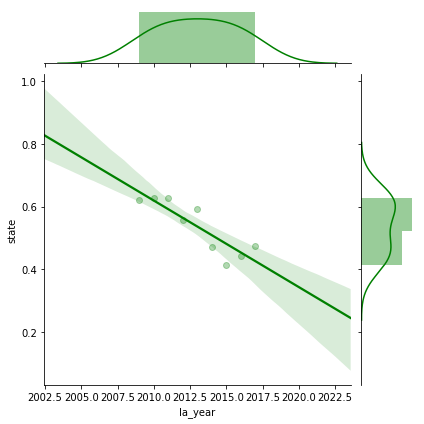

In [44]:
import seaborn as sns
sns.jointplot(x='la_year',y='state', kind='reg', color='g', data=state_mean_by_year, scatter_kws={'alpha':0.3})

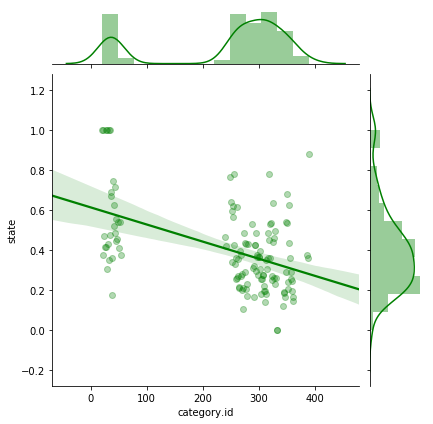

In [48]:
sns.jointplot(x='category.id',y='state', kind='reg', color='g', data=state_mean_by_cat, scatter_kws={'alpha':0.3})

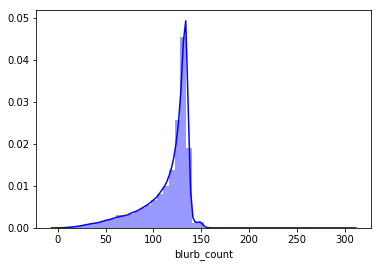

In [54]:
sns.distplot(df_trimmed["blurb_count"], color='b')

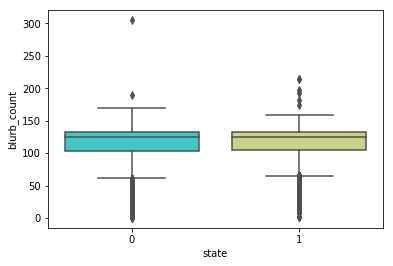

In [65]:
sns.boxplot(x='state', y='blurb_count', data=df_trimmed ,palette='rainbow')

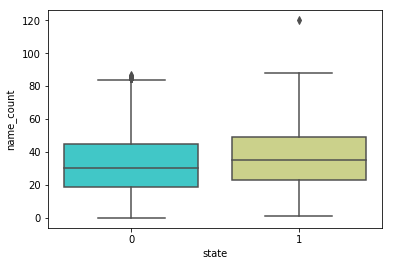

In [66]:
sns.boxplot(x='state', y='name_count', data=df_trimmed ,palette='rainbow')

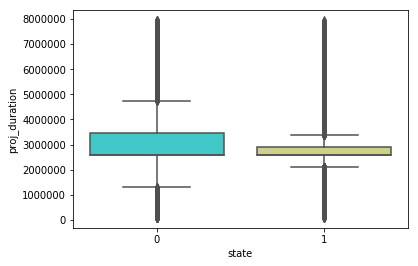

In [64]:
sns.boxplot(x='state', y='proj_duration', data=df_trimmed ,palette='rainbow')

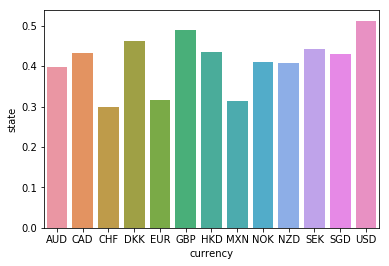

In [74]:
success_by_currency = df_trimmed.groupby("currency")["state"].mean().reset_index()
sns.barplot(x='currency', y="state", data=success_by_currency)

In [97]:
success_with_creator_slug = df_trimmed.groupby("state")["creator.slug"].value_counts()
df = pd.DataFrame(success_with_creator_slug)
df.columns = ["count"]

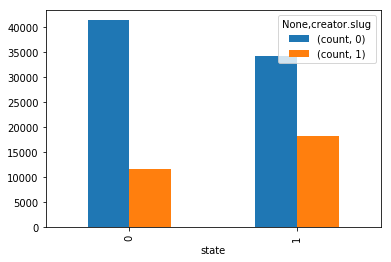

In [98]:
df.unstack().plot(kind='bar')

In [99]:
success_with_profile_url = df_trimmed.groupby("state")["profile.link_url"].value_counts()
df_prof_url = pd.DataFrame(success_with_profile_url)
df_prof_url.columns = ["count"]
df_prof_url

count
state profile.link_url       
0     0                 53046
1     0                 41381
      1                 11176

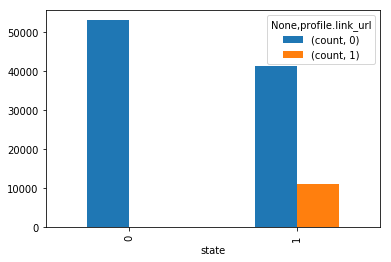

In [100]:
df_prof_url.unstack().plot(kind='bar')

In [102]:
# The above graphic and the data below show that projects that ALL projects that had a profile.link_url were successful!
df_trimmed.groupby("profile.link_url")["state"].value_counts()

profile.link_url  state
0                 0        53046
                  1        41381
1                 1        11176
Name: state, dtype: int64

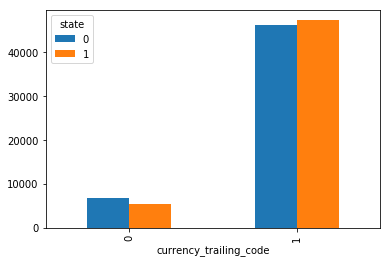

In [106]:
df_trimmed['currency_trailing_code'] = df_trimmed['currency_trailing_code'].replace([False, True], [0, 1])
df_curr = df_trimmed.groupby('currency_trailing_code')["state"].value_counts()
df_curr.columns = ["count"]
df_curr.unstack().plot(kind='bar')

In [108]:
# Convert categorical data to category type and encode
df_trimmed["currency_trailing_code"] = df_trimmed["currency_trailing_code"].astype("category")
df_trimmed["currency"] = df_trimmed["currency"].astype("category")
df_trimmed["location.country"] = df_trimmed["location.country"].astype("category")
df_trimmed["location.state"] = df_trimmed["location.state"].astype("category")
df_trimmed["location.name"] = df_trimmed["location.name"].astype("category")
df_trimmed["location.type"] = df_trimmed["location.type"].astype("category")
df_trimmed["category.name"] = df_trimmed["category.name"].astype("category")
df_trimmed["currency_trailing_code"] = df_trimmed["currency_trailing_code"].cat.codes
df_trimmed["currency"] = df_trimmed["currency"].cat.codes
df_trimmed["location.country"] = df_trimmed["location.country"].cat.codes
df_trimmed["location.state"] = df_trimmed["location.state"].cat.codes
df_trimmed["location.name"] = df_trimmed["location.name"].cat.codes
df_trimmed["location.type"] = df_trimmed["location.type"].cat.codes
df_trimmed["category.name"] = df_trimmed["category.name"].cat.codes

In [109]:
df_trimmed.head()

,currency,currency_trailing_code,state,location.country,location.state,location.id,location.name,location.type,category.id,category.name,category.parent_id,profile.link_url,profile.state_changed_at,creator.slug,name_count,blurb_count,goal_std,proj_duration,la_month,la_year
0,12,1,0,166,526,2478307,6727,7,273,82,12,0,1455845363,0,38.0,115.0,17380.000000,2588400,2,2016
1,12,1,0,82,812,1118370,8273,7,42,84,14,0,1475568868,0,24.0,73.0,24000.000000,3164346,12,2016
2,1,1,0,23,64,9807,8549,7,315,113,10,0,1425915865,0,43.0,131.0,37069.850800,2592000,7,2014
3,12,1,1,166,532,2352824,287,7,54,67,1,0,1425915825,0,32.0,121.0,1000.000000,2588400,2,2013
4,5,0,0,55,238,26062,4559,7,46,16,18,0,1425915838,0,46.0,100.0,1121.669045,2592000,9,2013


In [111]:
df_trimmed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105603 entries, 0 to 105602
Data columns (total 20 columns):
currency                    105603 non-null int8
currency_trailing_code      105603 non-null int8
state                       105603 non-null int64
location.country            105603 non-null int16
location.state              105603 non-null int16
location.id                 105603 non-null int64
location.name               105603 non-null int16
location.type               105603 non-null int8
category.id                 105603 non-null int64
category.name               105603 non-null int8
category.parent_id          105603 non-null int64
profile.link_url            105603 non-null int32
profile.state_changed_at    105603 non-null int64
creator.slug                105603 non-null int32
name_count                  105603 non-null float64
blurb_count                 105603 non-null float64
goal_std                    105603 non-null float64
proj_duration               105603 no

In [112]:
# We now label the target variable y, and drop it from the feature matrix, which we label X
y = df_trimmed[["state"]]
X = df_trimmed.drop(["state"], axis=1)

In [113]:
# Check dimensions of X and y 
print(X.shape)
print(y.shape)
X.head()

(105603, 19)
(105603, 1)


,currency,currency_trailing_code,location.country,location.state,location.id,location.name,location.type,category.id,category.name,category.parent_id,profile.link_url,profile.state_changed_at,creator.slug,name_count,blurb_count,goal_std,proj_duration,la_month,la_year
0,12,1,166,526,2478307,6727,7,273,82,12,0,1455845363,0,38.0,115.0,17380.000000,2588400,2,2016
1,12,1,82,812,1118370,8273,7,42,84,14,0,1475568868,0,24.0,73.0,24000.000000,3164346,12,2016
2,1,1,23,64,9807,8549,7,315,113,10,0,1425915865,0,43.0,131.0,37069.850800,2592000,7,2014
3,12,1,166,532,2352824,287,7,54,67,1,0,1425915825,0,32.0,121.0,1000.000000,2588400,2,2013
4,5,0,55,238,26062,4559,7,46,16,18,0,1425915838,0,46.0,100.0,1121.669045,2592000,9,2013


In [114]:
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

In [115]:
# Scale the training data
scaler = StandardScaler()
scaler.fit(X_train)
scaled_X = scaler.transform(X_train)
scaled_X

C:\Users\david\Miniconda3\envs\ads03\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int8, int16, int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\david\Miniconda3\envs\ads03\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype int8, int16, int32, int64, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until


array([[ 0.4492359 ,  0.35908386,  0.48306815, ..., -0.28759846,
         0.51661519,  1.14051746],
       [ 0.4492359 ,  0.35908386,  0.48306815, ...,  0.86243209,
         1.41888993, -1.65008563],
       [ 0.4492359 ,  0.35908386,  0.48306815, ...,  2.11066177,
         0.21585694,  0.02427622],
       ...,
       [ 0.4492359 ,  0.35908386,  0.48306815, ..., -1.48672857,
         0.21585694,  0.58239684],
       [ 0.4492359 ,  0.35908386,  0.48306815, ..., -1.08701853,
        -0.38565955, -1.09196501],
       [ 0.4492359 ,  0.35908386,  0.48306815, ..., -0.29092938,
        -1.28793429,  0.02427622]])

In [136]:
# Scale the test data
X_test_scaled = scaler.transform(X_test)

C:\Users\david\Miniconda3\envs\ads03\lib\site-packages\ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype int8, int16, int32, int64, float64 were all converted to float64 by StandardScaler.
  """Entry point for launching an IPython kernel.


In [117]:
# Initiate model instances and create list
log_reg = LogisticRegression()
for_clf = RandomForestClassifier()
xgb_clf = XGBClassifier()
models = [('Logisitic Regression', log_reg), ('Random Forest', for_clf), ('XGBoost', xgb_clf)]

In [139]:
# Fit and predict with models using KFold. Extract metric data for each model
for model in models:
    model_name = model[0]
    model = model[1]
    
    accuracy = []
    precision = []
    recall = []
    f1 = []
    auc = []
    
    kf = KFold(5, random_state=42, shuffle=True) 
    for train_idx, test_idx in kf.split(X, y=y):
        model.fit(scaled_X, y_train)
        y_pred = model.predict(X_test_scaled)
        accuracy.append(accuracy_score(y_test, y_pred))
        precision.append(precision_score(y_test, y_pred))
        recall.append(recall_score(y_test, y_pred))
        f1.append(f1_score(y_test, y_pred))
        auc.append(roc_auc_score(y_test, y_pred))
        
    mean_accuracy = np.mean(accuracy)
    mean_precision = np.mean(precision)
    mean_recall = np.mean(recall)
    mean_f1 = np.mean(f1)
    mean_auc = np.mean(auc)
    
    print(model)
    print('\t==============================')
    print('\tAccuracy:', mean_accuracy)
    print('\tPrecision:', mean_precision)
    print('\tRecall:', mean_recall)
    print('\tF1 score:', mean_f1)
    print('\tAUC:', mean_auc)
    print('\n')
    print(confusion_matrix(y_test,y_pred))
    print(classification_report(y_test,y_pred))

C:\Users\david\Miniconda3\envs\ads03\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\david\Miniconda3\envs\ads03\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\david\Miniconda3\envs\ads03\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\david\Miniconda3\envs\ads03\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\d

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
	Accuracy: 0.7060338623536987
	AUC: 0.7060477757234174


[[9324 3938]
 [3823 9316]]
              precision    recall  f1-score   support

           0       0.71      0.70      0.71     13262
           1       0.70      0.71      0.71     13139

   micro avg       0.71      0.71      0.71     26401
   macro avg       0.71      0.71      0.71     26401
weighted avg       0.71      0.71      0.71     26401



C:\Users\david\Miniconda3\envs\ads03\lib\site-packages\ipykernel_launcher.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
C:\Users\david\Miniconda3\envs\ads03\lib\site-packages\ipykernel_launcher.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
C:\Users\david\Miniconda3\envs\ads03\lib\site-packages\ipykernel_launcher.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
C:\Users\david\Miniconda3\envs\ads03\lib\site-packages\ipykernel_launcher.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
C:\Users\david\Miniconda3\envs\ads03\lib\site-packages\i

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
	Accuracy: 0.770410211734404
	AUC: 0.7700049563436705


[[11350  1912]
 [ 4193  8946]]
              precision    recall  f1-score   support

           0       0.73      0.86      0.79     13262
           1       0.82      0.68      0.75     13139

   micro avg       0.77      0.77      0.77     26401
   macro avg       0.78      0.77      0.77     26401
weighted avg       0.78      0.77      0.77     26401



C:\Users\david\Miniconda3\envs\ads03\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\david\Miniconda3\envs\ads03\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\david\Miniconda3\envs\ads03\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\david\Miniconda3\envs\ads03\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array w

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)
	Accuracy: 0.7723192303321844
	AUC: 0.772025757928213


[[11074  2188]
 [ 3823  9316]]
              precision    recall  f1-score   support

           0       0.74      0.84      0.79     13262
           1       0.81      0.71      0.76     13139

   micro avg       0.77      0.77      0.77     26401
   macro avg       0.78      0.77      0.77     26401
weighted avg       0.78      0.77      0.77     26401



In [133]:
# Check feature importances for XGBoost model
xgb_feat = zip(X.columns, xgb_clf.feature_importances_)
sorted(xgb_feat, key=lambda x: x[1], reverse=True)

[('category.id', 0.2954955),
 ('goal_std', 0.16396396),
 ('category.name', 0.15855856),
 ('profile.link_url', 0.08288288),
 ('proj_duration', 0.075675674),
 ('la_year', 0.03963964),
 ('name_count', 0.036036037),
 ('profile.state_changed_at', 0.025225226),
 ('location.id', 0.01981982),
 ('category.parent_id', 0.01981982),
 ('creator.slug', 0.01981982),
 ('blurb_count', 0.018018018),
 ('location.name', 0.012612613),
 ('currency', 0.009009009),
 ('location.state', 0.0072072074),
 ('la_month', 0.0072072074),
 ('currency_trailing_code', 0.0054054055),
 ('location.type', 0.0036036037),
 ('location.country', 0.0)]

In [134]:
# Check feature importances for Random Forest Classifier
for_feat = zip(X.columns, for_clf.feature_importances_)
sorted(for_feat, key=lambda x: x[1], reverse=True)

[('category.id', 0.13014376990727605),
 ('profile.link_url', 0.11406254694657995),
 ('goal_std', 0.10202664985323148),
 ('category.name', 0.08304065764914485),
 ('name_count', 0.07019758727314163),
 ('proj_duration', 0.06829153868246564),
 ('blurb_count', 0.06382337642766583),
 ('location.name', 0.061427061143002074),
 ('location.id', 0.06052353922569185),
 ('location.state', 0.049166422522641785),
 ('la_month', 0.046169805718887784),
 ('profile.state_changed_at', 0.040660862972506866),
 ('category.parent_id', 0.038153487209798),
 ('la_year', 0.034609329736405695),
 ('creator.slug', 0.01340300343853119),
 ('location.country', 0.008927841818400815),
 ('currency', 0.007127551455055174),
 ('location.type', 0.0054284539380292),
 ('currency_trailing_code', 0.0028165140815441295)]

In [137]:
for_clf = RandomForestClassifier()
param_grid = [{'n_estimators': [10, 100, 500, 1000],'max_features': ['auto', 'sqrt', 'log2']}]
grid_for = GridSearchCV(for_clf, param_grid,refit=True,verbose=2, scoring='accuracy', n_jobs=-1)
grid_for.fit(scaled_X, y_train)
y_preds = grid.predict(X_test_scaled)
best_params = grid_for.best_params_
best_estimator = grid_for.best_estimator_
best_cm = confusion_matrix(y_test, y_preds)
best_cr = classification_report(y_test, y_preds)
print(best_params, best_estimator, best_cm, best_cr)

C:\Users\david\Miniconda3\envs\ads03\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed: 11.5min finished
C:\Users\david\Miniconda3\envs\ads03\lib\site-packages\sklearn\model_selection\_search.py:740: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


{'max_features': 'auto', 'n_estimators': 1000} RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False) [[11426  1836]
 [ 3559  9580]]               precision    recall  f1-score   support

           0       0.76      0.86      0.81     13262
           1       0.84      0.73      0.78     13139

   micro avg       0.80      0.80      0.80     26401
   macro avg       0.80      0.80      0.79     26401
weighted avg       0.80      0.80      0.79     26401



In [138]:
cv_res_for = pd.DataFrame(grid_for.cv_results_)
cv_res_for

C:\Users\david\Miniconda3\envs\ads03\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\david\Miniconda3\envs\ads03\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\david\Miniconda3\envs\ads03\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\david\Mini

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,3.052486,0.013264,0.213454,0.036790,auto,10,"{'max_features': 'auto', 'n_estimators': 10}",0.764033,0.768977,0.765227,0.766079,0.002106,12,0.986705,0.986970,0.987008,0.986894,0.000135
1,27.017906,0.531850,1.575907,0.005043,auto,100,"{'max_features': 'auto', 'n_estimators': 100}",0.786607,0.787311,0.792500,0.788806,0.002628,7,1.000000,1.000000,0.999981,0.999994,0.000009
2,130.070214,0.872820,7.792521,0.335792,auto,500,"{'max_features': 'auto', 'n_estimators': 500}",0.791493,0.787727,0.794280,0.791167,0.002685,6,1.000000,1.000000,1.000000,1.000000,0.000000
3,258.960886,0.431964,21.350807,2.645535,auto,1000,"{'max_features': 'auto', 'n_estimators': 1000}",0.793008,0.788485,0.795000,0.792164,0.002726,1,1.000000,1.000000,1.000000,1.000000,0.000000
4,2.798937,0.028719,0.169203,0.004603,sqrt,10,"{'max_features': 'sqrt', 'n_estimators': 10}",0.768389,0.765076,0.768182,0.767215,0.001515,10,0.987443,0.986705,0.987955,0.987368,0.000513
5,26.088680,0.153085,1.543653,0.020227,sqrt,100,"{'max_features': 'sqrt', 'n_estimators': 100}",0.784448,0.785530,0.792614,0.787531,0.003621,8,1.000000,1.000000,1.000000,1.000000,0.000000
6,128.570381,0.715971,7.855138,0.289259,sqrt,500,"{'max_features': 'sqrt', 'n_estimators': 500}",0.791190,0.788447,0.794432,0.791356,0.002446,3,1.000000,1.000000,1.000000,1.000000,0.000000
7,267.335666,0.016235,20.678698,4.178570,sqrt,1000,"{'max_features': 'sqrt', 'n_estimators': 1000}",0.790887,0.787765,0.795303,0.791318,0.003092,5,1.000000,1.000000,1.000000,1.000000,0.000000
8,2.775395,0.109319,0.164797,0.002749,log2,10,"{'max_features': 'log2', 'n_estimators': 10}",0.765927,0.763220,0.769962,0.766370,0.002770,11,0.986402,0.987103,0.986648,0.986718,0.000290
9,27.099001,1.159630,1.675791,0.064660,log2,100,"{'max_features': 'log2', 'n_estimators': 100}",0.786493,0.784621,0.791023,0.787379,0.002687,9,1.000000,0.999981,1.000000,0.999994,0.000009


In [140]:
xgb_clf = XGBClassifier()
param_grid = [{'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['binary:logistic','reg:linear'],
              'learning_rate': [0.05,0.1], #so called `eta` value
              'max_depth': [6],
              'min_child_weight': [11],
              'silent': [1],
              'subsample': [0.8],
              'colsample_bytree': [0.7,0.8],
              'n_estimators': [5,500, 1000], #number of trees, change it to 1000 for better results
              'missing':[-999],
              'seed': [0,1337]}]
grid_xgb = GridSearchCV(xgb_clf, param_grid, refit=True,verbose=2, scoring='accuracy', n_jobs=-1)
grid_xgb.fit(scaled_X, y_train)
y_preds = grid_xgb.predict(X_test_scaled)
best_params = grid_xgb.best_params_
best_estimator = grid_xgb.best_estimator_
best_cm = confusion_matrix(y_test, y_preds)
best_cr = classification_report(y_test, y_preds)
print(best_params, best_estimator, best_cm, best_cr)

C:\Users\david\Miniconda3\envs\ads03\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed: 17.2min finished
C:\Users\david\Miniconda3\envs\ads03\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\david\Miniconda3\envs\ads03\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 6, 'min_child_weight': 11, 'missing': -999, 'n_estimators': 1000, 'nthread': 4, 'objective': 'reg:linear', 'seed': 0, 'silent': 1, 'subsample': 0.8} XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.7, gamma=0, learning_rate=0.05, max_delta_step=0,
       max_depth=6, min_child_weight=11, missing=-999, n_estimators=1000,
       n_jobs=1, nthread=4, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0, silent=1,
       subsample=0.8) [[11420  1842]
 [ 3300  9839]]               precision    recall  f1-score   support

           0       0.78      0.86      0.82     13262
           1       0.84      0.75      0.79     13139

   micro avg       0.81      0.81      0.81     26401
   macro avg       0.81      0.80      0.80     26401
weighted avg       0.81      0.81      0.80     26401



In [141]:
cv_res_xgb = pd.DataFrame(grid_xgb.cv_results_)
cv_res_xgb

C:\Users\david\Miniconda3\envs\ads03\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\david\Miniconda3\envs\ads03\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\david\Miniconda3\envs\ads03\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\david\Mini

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bytree,param_learning_rate,param_max_depth,param_min_child_weight,param_missing,param_n_estimators,param_nthread,param_objective,param_seed,param_silent,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0.613359,0.108238,0.067817,0.028361,0.7,0.05,6,11,-999,5,4,binary:logistic,0,1,0.8,"{'colsample_bytree': 0.7, 'learning_rate': 0.0...",0.761003,0.762083,0.761667,0.761584,0.000445,40,0.764981,0.767414,0.761259,0.764551,0.002531
1,0.648601,0.023946,0.040891,0.002931,0.7,0.05,6,11,-999,5,4,binary:logistic,1337,1,0.8,"{'colsample_bytree': 0.7, 'learning_rate': 0.0...",0.751345,0.763182,0.769205,0.761243,0.007419,41,0.758409,0.768399,0.767111,0.764640,0.004437
2,0.633635,0.061101,0.040226,0.002350,0.7,0.05,6,11,-999,5,4,reg:linear,0,1,0.8,"{'colsample_bytree': 0.7, 'learning_rate': 0.0...",0.760738,0.763068,0.761742,0.761849,0.000954,38,0.764053,0.768172,0.760464,0.764229,0.003149
3,0.651585,0.040200,0.034241,0.009006,0.7,0.05,6,11,-999,5,4,reg:linear,1337,1,0.8,"{'colsample_bytree': 0.7, 'learning_rate': 0.0...",0.753238,0.763485,0.769470,0.762064,0.006702,37,0.759697,0.768740,0.767414,0.765284,0.003987
4,52.845897,3.807613,0.512628,0.037564,0.7,0.05,6,11,-999,500,4,binary:logistic,0,1,0.8,"{'colsample_bytree': 0.7, 'learning_rate': 0.0...",0.800242,0.797765,0.803144,0.800384,0.002198,7,0.835928,0.836294,0.834779,0.835667,0.000645
5,53.329268,3.109988,0.607707,0.015328,0.7,0.05,6,11,-999,500,4,binary:logistic,1337,1,0.8,"{'colsample_bytree': 0.7, 'learning_rate': 0.0...",0.800508,0.798523,0.803485,0.800838,0.002039,3,0.836345,0.836105,0.835215,0.835888,0.000486
6,56.681966,4.217461,0.701456,0.067183,0.7,0.05,6,11,-999,500,4,reg:linear,0,1,0.8,"{'colsample_bytree': 0.7, 'learning_rate': 0.0...",0.802553,0.796667,0.804621,0.801280,0.003370,2,0.842746,0.844324,0.841995,0.843022,0.000971
7,52.910059,0.506670,0.645604,0.090716,0.7,0.05,6,11,-999,500,4,reg:linear,1337,1,0.8,"{'colsample_bytree': 0.7, 'learning_rate': 0.0...",0.798576,0.798409,0.803485,0.800157,0.002354,10,0.844811,0.844002,0.841767,0.843527,0.001287
8,103.711441,3.183856,1.194133,0.107608,0.7,0.05,6,11,-999,1000,4,binary:logistic,0,1,0.8,"{'colsample_bytree': 0.7, 'learning_rate': 0.0...",0.799258,0.796970,0.803030,0.799753,0.002499,15,0.862008,0.863357,0.861198,0.862188,0.000891
9,102.350081,3.141189,1.150253,0.220553,0.7,0.05,6,11,-999,1000,4,binary:logistic,1337,1,0.8,"{'colsample_bytree': 0.7, 'learning_rate': 0.0...",0.797780,0.798674,0.802955,0.799803,0.002258,13,0.862121,0.861596,0.861691,0.861803,0.000228


In [54]:
X_test_sc = sc.transform(X_test)
best_xgb = xgb_gridCV.best_estimator_
best_xgb.fit(scaled_X, y_train)
best_xgb.score(X_test_sc, y_test)

C:\Users\david\Miniconda3\envs\ads03\lib\site-packages\ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype int8, int16, int32, int64, float64 were all converted to float64 by StandardScaler.
  """Entry point for launching an IPython kernel.


0.7970152645733116